In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from skimage.io import imread
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation, GaussianNoise
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.constraints import maxnorm

## Загрузка набора данных и предварительный анализ

In [2]:
def draw_pictures(img_df):
    n = len(img_df)
    cols = 5
    if n < cols:
        cols = n
    rows = n//cols+1 if (n/cols > n//cols) else n//cols
    plt.subplots(squeeze=False, figsize=(10, 10))
    for i in range(n):
        plt.subplot2grid((rows, cols), (i//cols, i % cols)
                         ).imshow(imread(df['path'][i]))


In [3]:
def draw_image_hist(img_path):
    image = imread(img_path)
    plt.hist(image.ravel(), bins = 256, color = 'orange')
    plt.hist(image[:, :, 0].ravel(), bins = 256, color = 'red', alpha = 0.5)
    plt.hist(image[:, :, 1].ravel(), bins = 256, color = 'Green', alpha = 0.5)
    plt.hist(image[:, :, 2].ravel(), bins = 256, color = 'Blue', alpha = 0.5)
    plt.xlabel('Интенсивность')
    plt.ylabel('Количество')
    plt.legend(['Общая', 'Красный канал', 'Зелёный канал', 'Синий канал'])
  

In [4]:
def draw_pictures_with_hists(img_df):
    n = len(img_df)
    cols = 5
    if n < cols:
        cols = n
    rows = n//cols+1 if (n/cols > n//cols) else n//cols
    fig, axes = plt.subplots(rows*2, cols, figsize=(cols*5,rows*10))
    plt.suptitle('Цветовая гистограмма')
    row_i =0
    for i in range(n):
        image = imread(df['path'][i])
        axes[row_i, i%cols].hist(image.ravel(), bins = 256, color = 'orange', )
        axes[row_i, i%cols].hist(image[:, :, 0].ravel(), bins = 256, color = 'red', alpha = 0.5)
        axes[row_i, i%cols].hist(image[:, :, 1].ravel(), bins = 256, color = 'green', alpha = 0.5)
        axes[row_i, i%cols].hist(image[:, :, 2].ravel(), bins = 256, color = 'blue', alpha = 0.5)
        axes[row_i, i%cols].legend(['Общая', 'Красный канал', 'Зелёный канал', 'Синий канал'])
        axes[row_i, i%cols].set_xlabel('Интенсивность')
        axes[row_i, i%cols].set_ylabel('Количество')
        axes[row_i+1, i%cols].imshow(image)
        if (i%cols+1 == cols):
            row_i += 2

        

In [5]:
image_path = "../data/Raw/"
image_files = []
global classes_dict 
classes_dict = {}
for k, dir in enumerate(os.listdir(image_path)):
    classes_dict[dir.lower()] = k
    image_files.extend(os.path.join(image_path, dir, file) for file in os.listdir(os.path.join(image_path, dir)) if file.endswith(('.JPG', '.jpg')))

In [6]:
for class_title, class_number in classes_dict.items():
    print (f"Класс: \033[1m{class_title}\033[0m - номер {class_number}")

Класс: bottle_opener - номер 0
Класс: can_opener - номер 1
Класс: dinner_fork - номер 2
Класс: fish_slice - номер 3


In [7]:
def img_params(img_path):
    img = imread(img_path) 
    img_class = img_path.replace(image_path, '').split('\\')[0].lower()
    return classes_dict[img_class], img_path, img.shape[0], img.shape[1], img.shape[2], img.max(), img.min(), img.mean(), img.std(), np.median(img)

In [8]:
images_data = np.array(list(map(img_params, np.asarray(image_files))))

In [10]:
df = pd.DataFrame(columns=['img_class','path','height', 'width', 'dimension', 'max_rgb', 'min_rgb', 'mean_rgb', 'std_rgb', 'median_rgb'], data=images_data)
df = df.astype({'height': 'int32', 'width': 'int32', 'dimension': 'int32', 'max_rgb': 'float32',
          'min_rgb': 'float32', 'mean_rgb': 'float32', 'std_rgb': 'float32', 'median_rgb': 'float32'})


img_class - класс, к которому относится изображение

path - путь к файлу изображения

height - высота изображения

width - ширина изображения

dimension - количество цветовых каналов изображения

max_rgb - максимальное значение пикселя в изображении

min_rgb - минимальное значение пикселя в изображении

mean_rgb - среднее значение пикселя в изображении

std_rgb  - стандартное отклонение значения пикселя в изображении



In [11]:
print('Первые 5 строчек датасета:')
df.head()

Первые 5 строчек датасета:


,img_class,path,height,width,dimension,max_rgb,min_rgb,mean_rgb,std_rgb,median_rgb
0,0,../data/Raw/BOTTLE_OPENER\bottleopenerraw1.JPG,1536,2048,3,255.0,0.0,54.986946,34.352425,47.0
1,0,../data/Raw/BOTTLE_OPENER\bottleopenerraw10.JPG,1536,2048,3,255.0,0.0,138.947037,68.768059,157.0
2,0,../data/Raw/BOTTLE_OPENER\bottleopenerraw11.JPG,1536,2048,3,255.0,0.0,145.557602,69.073090,166.0
3,0,../data/Raw/BOTTLE_OPENER\bottleopenerraw12.JPG,1536,2048,3,255.0,0.0,129.254044,68.981476,145.0
4,0,../data/Raw/BOTTLE_OPENER\bottleopenerraw13.JPG,1536,2048,3,255.0,0.0,132.945312,62.024948,143.0


Первые 5 изображений датасета:


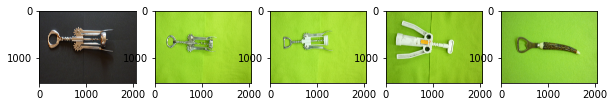

In [12]:
print('Первые 5 изображений датасета:')
draw_pictures(df[:5])

In [13]:
print(f'Количество фотографий в датасете: {df.shape[0]}')
print('Количество отсутствующих значений в датасете и типы данных по столбцам:\n')
print(df.info())

Количество фотографий в датасете: 190
Количество отсутствующих значений в датасете и типы данных по столбцам:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190 entries, 0 to 189
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   img_class   190 non-null    object 
 1   path        190 non-null    object 
 2   height      190 non-null    int32  
 3   width       190 non-null    int32  
 4   dimension   190 non-null    int32  
 5   max_rgb     190 non-null    float32
 6   min_rgb     190 non-null    float32
 7   mean_rgb    190 non-null    float32
 8   std_rgb     190 non-null    float32
 9   median_rgb  190 non-null    float32
dtypes: float32(5), int32(3), object(2)
memory usage: 9.0+ KB
None


## Описательный анализ данных

Описание численных типов данных

In [14]:
df.describe()

,height,width,dimension,max_rgb,min_rgb,mean_rgb,std_rgb,median_rgb
count,190.000000,190.000000,190.0,190.000000,190.000000,190.000000,190.000000,190.000000
mean,1823.757895,2169.542105,3.0,251.289474,0.589474,113.697121,58.728706,123.947365
std,1031.165752,1035.053078,0.0,11.910841,4.300842,41.704659,13.833957,53.891891
min,131.000000,169.000000,3.0,172.000000,0.000000,39.710236,20.020618,31.000000
25%,1536.000000,2048.000000,3.0,255.000000,0.000000,91.832638,53.910644,83.250000
50%,1536.000000,2048.000000,3.0,255.000000,0.000000,107.556919,60.978527,129.500000
75%,2322.000000,2322.000000,3.0,255.000000,0.000000,124.489517,67.222893,146.000000
max,4128.000000,4128.000000,3.0,255.000000,44.000000,246.682693,93.666809,255.000000


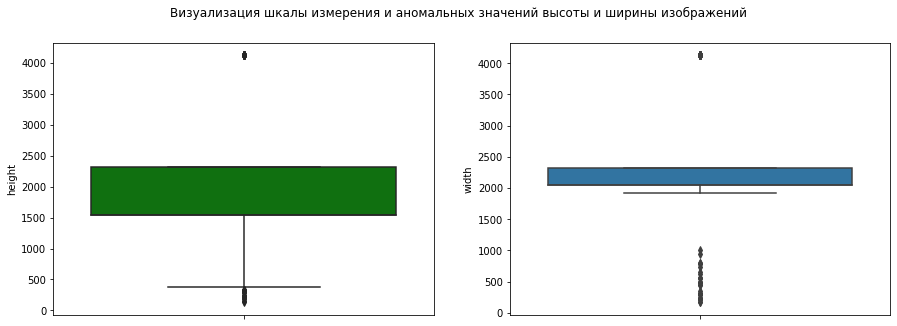

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Визуализация шкалы измерения и аномальных значений высоты и ширины изображений')
sns.boxplot(ax=axes[0], y="height", data=df, color='green')
sns.boxplot(ax=axes[1], y="width", data=df)
plt.show()

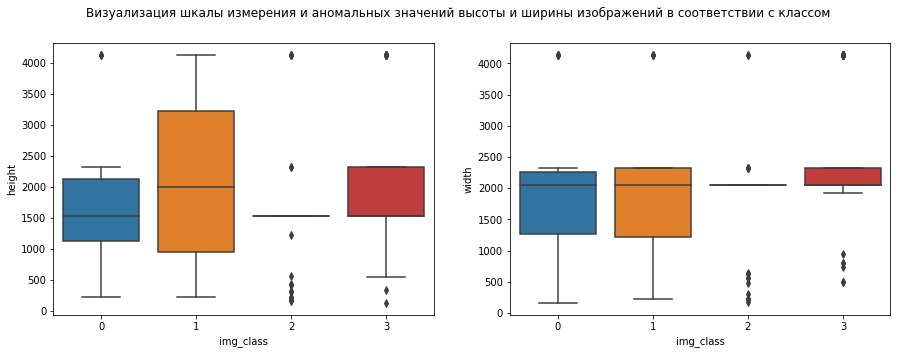

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Визуализация шкалы измерения и аномальных значений высоты и ширины изображений в соответствии с классом')
sns.boxplot(ax=axes[0], x="img_class", y="height", data=df)
sns.boxplot(ax=axes[1], x="img_class", y="width", data=df)
plt.show()

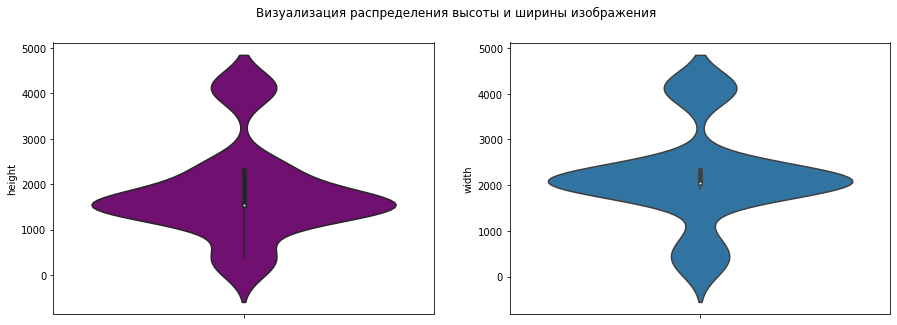

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Визуализация распределения высоты и ширины изображения ')
sns.violinplot(ax=axes[0], y = df['height'], color='purple')
sns.violinplot(ax=axes[1], y = df['width'])
plt.show()

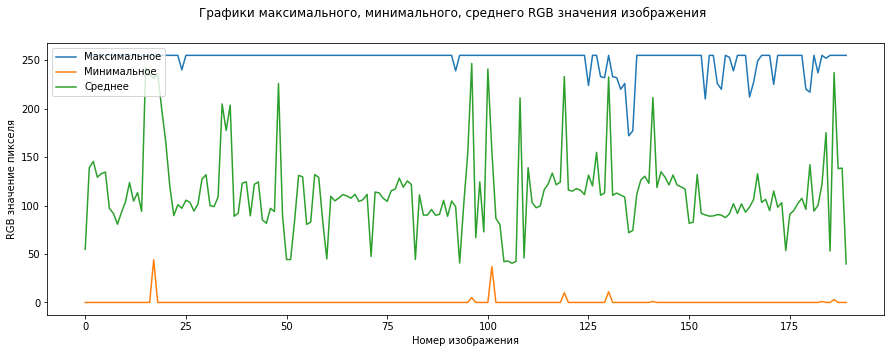

In [18]:
f, ax = plt.subplots(figsize=(15, 5))
f.suptitle('Графики максимального, минимального, среднего RGB значения изображения')
sns.lineplot(label='Максимальное', data=df['max_rgb'])
sns.lineplot(label='Минимальное', data=df['min_rgb'])
sns.lineplot(label='Среднее', data=df['mean_rgb'])
plt.legend(fontsize=10, loc='upper left')
plt.xlabel('Номер изображения')
plt.ylabel('RGB значение пикселя')
plt.show()

# Изменить вид std

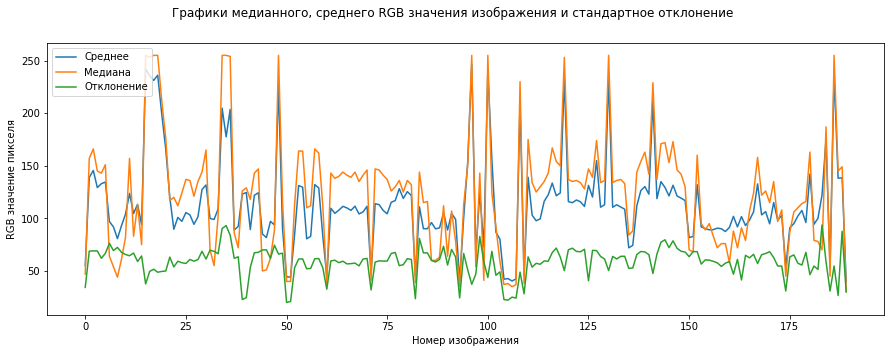

In [19]:
f, ax = plt.subplots(figsize=(15, 5))
f.suptitle('Графики медианного, среднего RGB значения изображения и стандартное отклонение')
sns.lineplot(label='Среднее', data=df['mean_rgb'])
sns.lineplot(label='Медиана', data=df['median_rgb'])
sns.lineplot(label='Отклонение', data=df['std_rgb'])
plt.legend(fontsize=10, loc='upper left')
plt.xlabel('Номер изображения')
plt.ylabel('RGB значение пикселя')
plt.show()

Описание категориальных типов данных

In [20]:
df.describe(include = ['O'])

,img_class,path
count,190,190
unique,4,190
top,3,../data/Raw/BOTTLE_OPENER\bottleopenerraw1.JPG
freq,82,1


In [21]:
for class_title, class_number in classes_dict.items():
    print (f"Класс номер {class_number} {class_title}: {len(df[df['img_class'] == str(class_number)])} ({len(df[df['img_class'] == str(class_number)])/len(df)*100:.2f}%)")
print (f"Всего: {len(df)}")

Класс номер 0 bottle_opener: 30 (15.79%)
Класс номер 1 can_opener: 19 (10.00%)
Класс номер 2 dinner_fork: 59 (31.05%)
Класс номер 3 fish_slice: 82 (43.16%)
Всего: 190


Цветовые гистограммы по трём каналам

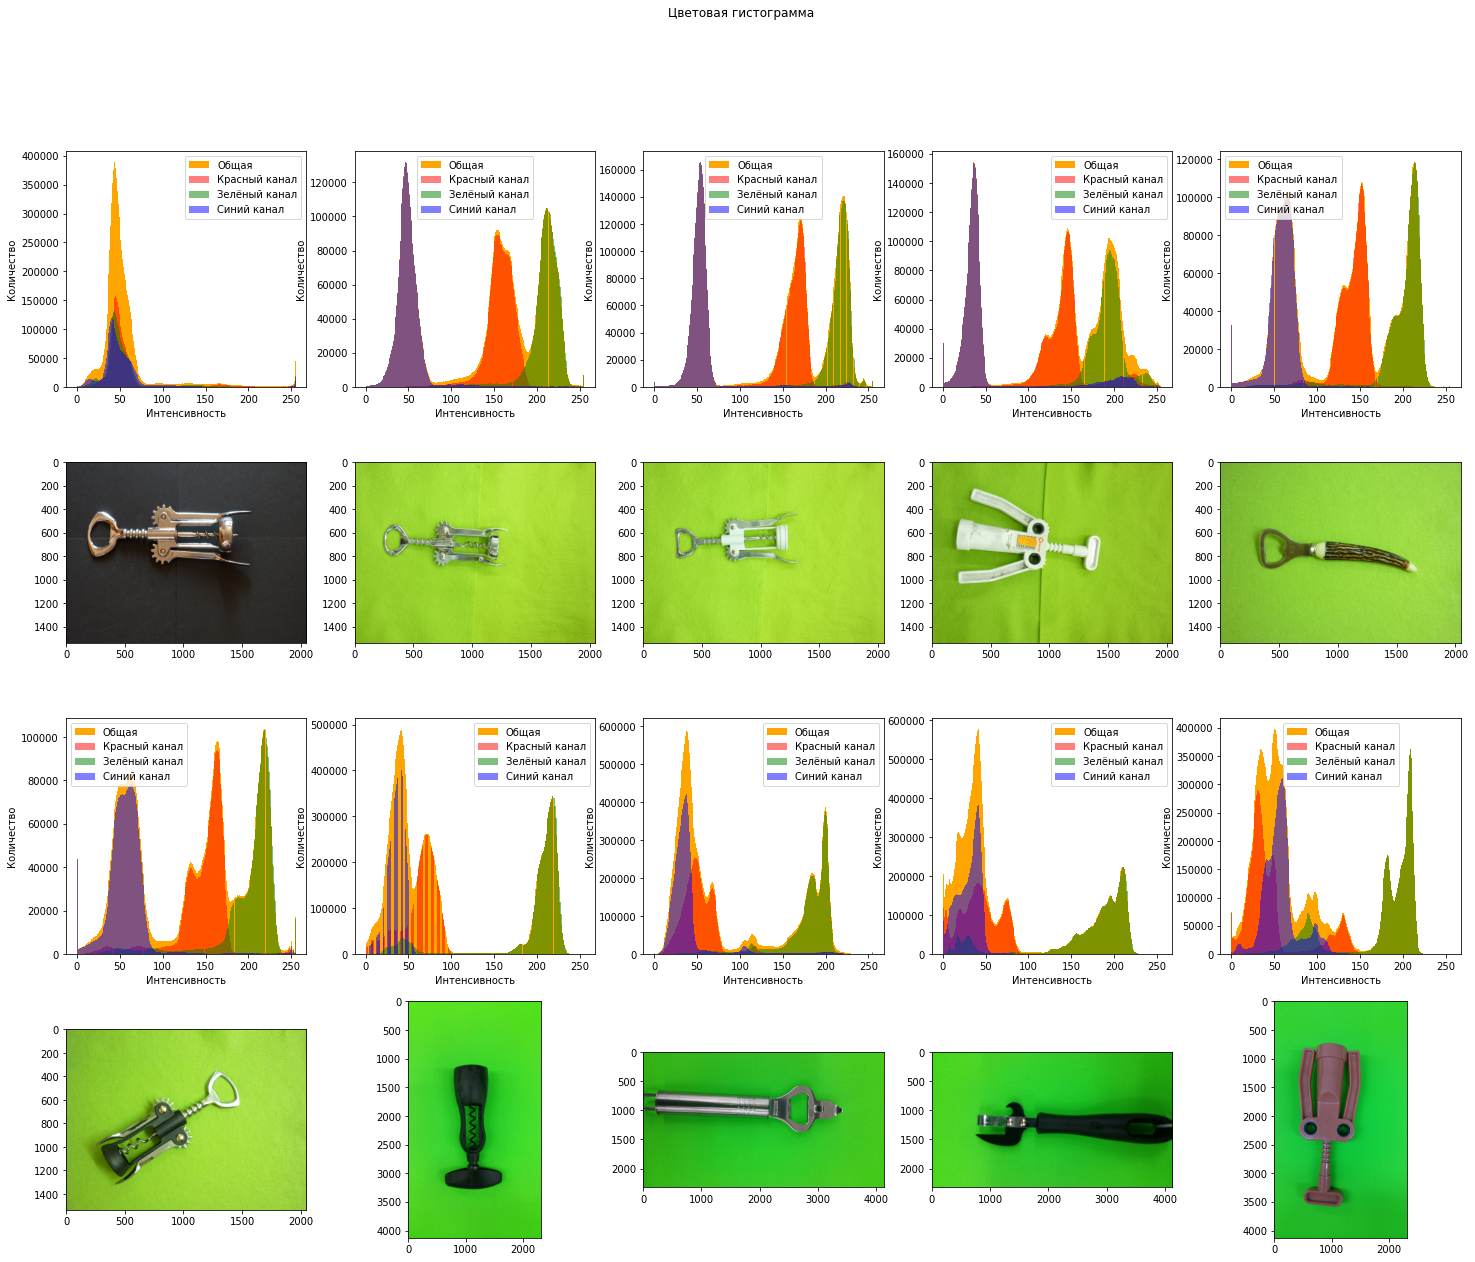

In [22]:
draw_pictures_with_hists(df[:10])

Корреляционная матрица датасета


<AxesSubplot:>

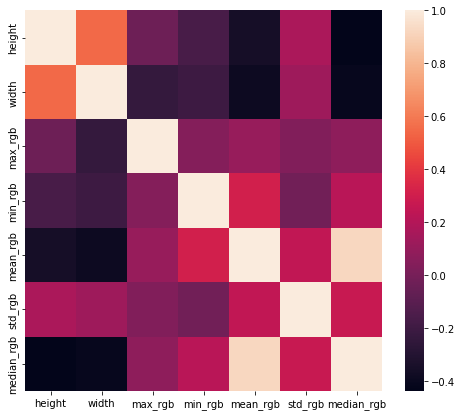

In [23]:
print("Корреляционная матрица датасета")
plt.rcParams['figure.figsize'] = (8,7)
sns.heatmap(df.drop('dimension', axis=1).corr())

Таблица рассеивания классов фотографий от всех факторов


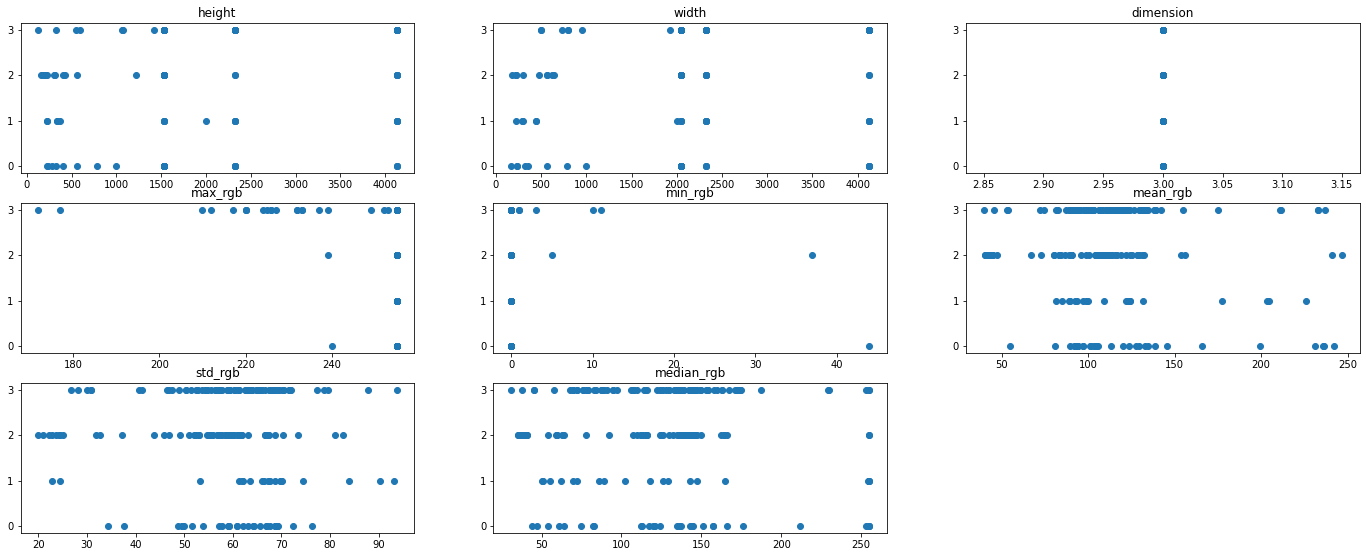

In [24]:
print('Таблица рассеивания классов фотографий от всех факторов')
plt.rcParams['figure.figsize'] = (24,16)
for i, col in enumerate(df.columns[2:]):
    plt.subplot(5, 3, i+1)
    plt.scatter(df[col], df['img_class'])
    plt.title(col)

## Добавление фото

In [25]:
seed = 21

In [26]:
rotation = 45
datagen = ImageDataGenerator(rotation_range=rotation, 
                             width_shift_range=0.2, 
                             height_shift_range=0.2, 
                             shear_range=0.2, 
                             zoom_range=0.3, 
                             horizontal_flip=True, 
                             vertical_flip=True, 
                             fill_mode="nearest")
for label in classes_dict.keys():
    res1 = datagen.flow_from_directory(image_path,
                                       batch_size=1,
                                       seed=seed,
                                       class_mode='categorical',
                                       save_to_dir=image_path + label,
                                       classes=[label],
                                       save_prefix=f"new_{label}",
                                       save_format="jpeg")

    n_augmentations = len(res1)*round((360/rotation))
    for _ in range(n_augmentations):
        next(res1)


Found 270 images belonging to 1 classes.
Found 171 images belonging to 1 classes.
Found 531 images belonging to 1 classes.
Found 738 images belonging to 1 classes.


## Моделирование

In [68]:
img_path = "../data/Raw/"
img_width = 128
img_height = 128
batch_size = 128
datagen = ImageDataGenerator(
    rescale=1. / 255., 
    samplewise_center=True,
    samplewise_std_normalization=True,
    validation_split=0.3)
train_generator = datagen.flow_from_directory(img_path, 
                                    subset='training',
                                    target_size=(img_height, img_width), 
                                    batch_size=batch_size, 
                                    shuffle=False, 
                                    class_mode='categorical', 
                                    color_mode='rgb')
test_generator = datagen.flow_from_directory(img_path, 
                                    subset='validation',
                                    target_size=(img_height, img_width), 
                                    batch_size=batch_size, 
                                    shuffle=False, 
                                    class_mode='categorical', 
                                    color_mode='rgb')


Found 10773 images belonging to 4 classes.
Found 4615 images belonging to 4 classes.


In [38]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

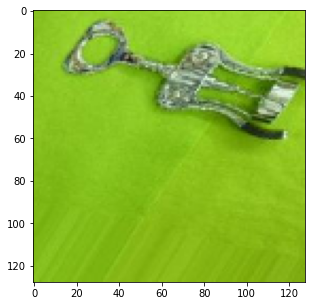

In [69]:
plt.figure(figsize=(5, 5))
plt.imshow(array_to_img(train_generator[2][0][0]))
plt.show()

In [70]:
class_num = train_generator.num_classes

Модель

In [71]:
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier
from keras.utils import np_utils

In [72]:
np.random.seed(seed)

In [73]:
x=np.concatenate([train_generator.next()[0] for i in range(train_generator.__len__())])
y=np.concatenate([train_generator.next()[1] for i in range(train_generator.__len__())])
print(x.shape)
print(y.shape)

KeyboardInterrupt: 

In [47]:
y = train_generator.classes
y = np_utils.to_categorical(y)

In [69]:
def create_model():
	# create model
	model = Sequential()
	model.add(Conv2D(2, (3, 3), input_shape=train_generator[0][0].shape[1:], padding='same', activation='hard_sigmoid'))# 2 8
	model.add(Flatten())
	model.add(Dense(16, kernel_constraint=maxnorm(3),kernel_initializer='glorot_uniform', activation='hard_sigmoid'))
	model.add(Dense(class_num, activation='linear'))
	# Compile model
	model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
	return model

In [70]:
# create model
model = KerasClassifier(model=create_model, verbose=0)
# define the grid search parameters
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [5, 10, 20, 25]
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
neurons = [2, 4, 8, 16, 32, 64, 128]
weight_constraint = [1, 2, 3, 4, 5]
dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

param_grid = dict(epochs=epochs)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3)
grid_result = grid.fit(x, y, epochs=10, batch_size=80)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param)) 

Best: 0.073350 using {'epochs': 10}
0.026895 (0.038035) with: {'epochs': 5}
0.073350 (0.103732) with: {'epochs': 10}
0.044010 (0.062239) with: {'epochs': 20}
0.000000 (0.000000) with: {'epochs': 25}


In [35]:
epochs = 10
optimizer = 'adam'
model = Sequential()
model.add(Conv2D(16, (3, 3), input_shape=train_generator[0][0].shape[1:], padding='same', activation='relu'))
model.add(Flatten())
model.add(Dense(12, kernel_constraint=maxnorm(3), activation='relu'))
model.add(Dense(class_num, activation='sigmoid'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [48]:
model = Sequential()
model.add(Conv2D(16, (3, 3), input_shape=train_generator[0][0].shape[1:], padding='same', activation='hard_sigmoid'))# 2 8
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(16, kernel_constraint=maxnorm(3),kernel_initializer='glorot_uniform', activation='hard_sigmoid'))
model.add(Dense(class_num, activation='linear'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [63]:
epochs = 1
batch_size = 80

In [64]:
history = model.fit(train_generator, validation_data=test_generator, epochs=epochs, batch_size=batch_size)

85/85 [==============================] - 422s 5s/step - loss: 1.2548 - accuracy: 0.4315 - val_loss: 1.2479 - val_accuracy: 0.4316


In [67]:
history.history

{'loss': [1.2548065185546875],
 'accuracy': [0.4315418303012848],
 'val_loss': [1.247897982597351],
 'val_accuracy': [0.4316359758377075]}

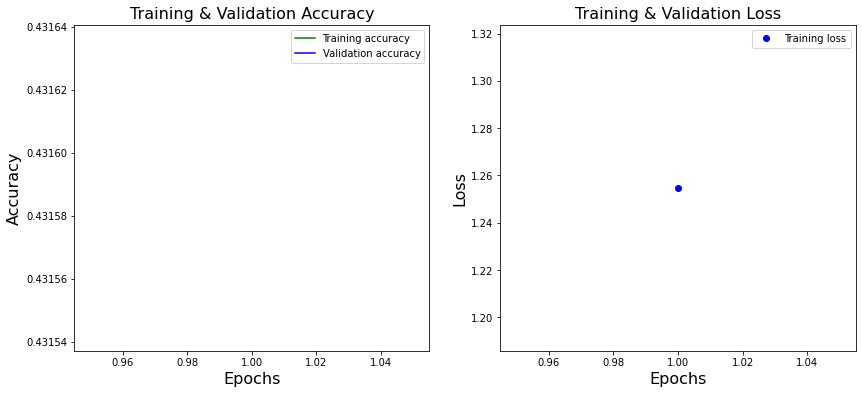

In [65]:
history_dict = history.history
loss_values = history_dict['loss']
#val_loss_values = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']
 
epochs = range(1, len(loss_values) + 1)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
#
# Plot the model accuracy vs Epochs
#
ax[0].plot(epochs, accuracy, 'g', label='Training accuracy')
ax[0].plot(epochs, val_accuracy, 'b', label='Validation accuracy')
ax[0].set_title('Training & Validation Accuracy', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Accuracy', fontsize=16)
ax[0].legend()
#
# Plot the loss vs Epochs
#
ax[1].plot(epochs, loss_values, 'bo', label='Training loss')
#ax[1].plot(epochs, val_loss_values, 'b', label='Validation loss')
ax[1].set_title('Training & Validation Loss', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Loss', fontsize=16)
ax[1].legend()

Оценка качества

In [16]:
scores = model.evaluate(test_generator, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 9.75%


In [9]:
scores

[3.1156322956085205, 0.11026615649461746]

In [33]:
epochs = 1
optimizer = 'adam'
model = Sequential()
model.add(Conv2D(16, (3, 3), input_shape=train_generator[0][0].shape[1:], padding='same', activation='relu'))
#model.add(Dropout(0.2))
#model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(BatchNormalization())
#model.add(Conv2D(8, (3, 3), padding='same', activation='relu'))
#model.add(Dropout(0.2))
#model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(BatchNormalization())
model.add(Flatten())
#model.add(Dropout(0.2))
model.add(Dense(64, kernel_constraint=maxnorm(3), activation='relu'))
#model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(32, kernel_constraint=maxnorm(3), activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(class_num))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [51]:
from sklearn.model_selection import learning_curve
# График с ошибкой
def plot_with_err(x, data, **kwargs):
    data_mean, data_std = data.mean(axis=1), data.std(axis=1)
    lines = plt.plot(x, data_mean, '-', **kwargs)
    plt.fill_between(x, data_mean - data_std, data_mean + data_std, edgecolor='none',
                     facecolor=lines[0].get_color(), alpha=0.2)

# Обучающие кривые
def print_learning_curve(model, x_train, y_train):
    train_sizes = np.linspace(0.1, 1, 20)
    _, train_scores, val_scores = learning_curve(
        model, x_train, y_train, train_sizes=train_sizes, cv=4)
    plt.figure('Learning Curve')
    plt.title('Learning Curve')
    plt.xlabel('Training Set Size')
    plt.ylabel('Score')
    plot_with_err(train_sizes, train_scores,
                  label='Training scores', color='red')
    plot_with_err(train_sizes, val_scores,
                  label='Validation scores', color='orange')
    plt.legend()
    plt.show()

In [52]:
print_learning_curve(model, x, y)

TypeError: If no scoring is specified, the estimator passed should have a 'score' method. The estimator <keras.engine.sequential.Sequential object at 0x000001F11CBD8248> does not.